In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf 
from keras.engine.topology import Layer
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, Add, Flatten, LSTM, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D, Lambda, Multiply, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD, Adadelta
from keras.models import Model
from keras import regularizers
from keras.preprocessing import sequence
import keras.backend as K
import numpy as np
from keras.datasets import imdb
import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

D:\Miniconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [262]:
import importlib
importlib.reload(preprocessing)

<module 'preprocessing' from 'D:\\jupyter-workdir\\nlp\\bg_fusion\\preprocessing.py'>

In [263]:
import os.path as osp
import pickle
wordCounter = preprocessing.WordCounter()
if not osp.isfile("E:/kaggle/avito/imdb_testset/aclImdb_v1/words_counter_list"):
    wordCounter.fit(["E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_neg.txt", "E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test_pos.txt"])
    pickle.dump(wordCounter.words_list, open("E:/kaggle/avito/imdb_testset/aclImdb_v1/words_counter_list", "wb"))
else:
    wordCounter.words_list = pickle.load(open("E:/kaggle/avito/imdb_testset/aclImdb_v1/words_counter_list", "rb"))

In [256]:
if False:
    import gensim
    if not osp.isfile("E:/kaggle/avito/imdb_testset/gensim_models/imdb_word2vec"):
        sentences = gensim.models.word2vec.PathLineSentences("E:/kaggle/avito/imdb_testset/aclImdb_v1/train_test/")
        model = gensim.models.Word2Vec(sentences, size=200, window=5, min_count=1, workers=8)
        model.save("E:/kaggle/avito/imdb_testset/gensim_models/imdb_word2vec")
    else:
        model = gensim.models.Word2Vec.load("E:/kaggle/avito/imdb_testset/gensim_models/imdb_word2vec")
    emdedings = wordCounter.get_pretrain_embedding(model, num_words=10000)

In [5]:
print("words count", len(wordCounter.words_list))

words count 181924


In [6]:
def getdata(num_words=None):
    state = np.random.RandomState(0)
    X_train_pos = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/train_pos.txt"], max_words=num_words))
    X_train_neg = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/train_neg.txt"], max_words=num_words))
    y_train_pos = np.ones(X_train_pos.shape[0])
    y_train_neg = np.zeros(X_train_neg.shape[0])
    X_test_pos = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/test_pos.txt"], max_words=num_words))
    X_test_neg = np.array(wordCounter.transform(["E:/kaggle/avito/imdb_testset/aclImdb_v1/test_neg.txt"], max_words=num_words))
    y_test_pos = np.ones(X_test_pos.shape[0])
    y_test_neg = np.zeros(X_test_neg.shape[0])
    X_train, y_train = np.concatenate([X_train_pos, X_train_neg]), np.concatenate([y_train_pos, y_train_neg])
    X_test, y_test = np.concatenate([X_test_pos, X_test_neg]), np.concatenate([y_test_pos, y_test_neg])
    train_permut = state.permutation(X_train.shape[0])
    test_permut = state.permutation(X_test.shape[0])
    return (X_train[train_permut], y_train[train_permut]), (X_test[test_permut], y_test[test_permut])

def ignore_highfreq_words(X_train, X_test, thresh = 1e-4):
    state = np.random.RandomState(0)
    wordsStat = wordCounter.getWordsStatistics(np.concatenate([X_train, X_test]), sample = thresh)
    for i, doc in enumerate(X_train):
        X_train[i] = [w for w in doc if w in wordsStat and wordsStat[w].sample_int > state.rand() * 2 ** 32]
    for i, doc in enumerate(X_test):
        X_test[i] = [w for w in doc if w in wordsStat and wordsStat[w].sample_int > state.rand() * 2 ** 32]
    return X_train, X_test, wordsStat

In [7]:
# (X_train, y_train), (X_test, y_test) = imdb.load_data(path="E:/paper/stackingmodel/imdb/imdb.npz", num_words=10000)
num_words = 30000
(X_train_o, y_train), (X_test_o, y_test) = getdata(num_words=num_words)

In [8]:
# X_train, X_test, wordsStat = ignore_highfreq_words(X_train, X_test, thresh = 0.001)

In [147]:
# # padding 
maxlen = 500
X_train = sequence.pad_sequences(X_train_o, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test_o, maxlen=maxlen, padding='post', truncating='post')

In [9]:
X_train = X_train_o
X_test = X_test_o

In [10]:
# X_train = preprocessing.WordCounter.ngram_one_hot(n_vocab=num_words, documents_indices=X_train)
# X_test = preprocessing.WordCounter.ngram_one_hot(n_vocab=num_words, documents_indices=X_test)

In [11]:
class SpatialPyramidPooling1D(Layer):
    def __init__(self, pool_list, mode = "max", **kwargs):
        self.pool_list = np.array(pool_list)
        self.mode = mode
        assert self.pool_list.ndim == 1, "pool_list ndim must be 1"
        assert self.mode in ["max", "avg"], "mode must be either max or avg"
        self.num_outputs = sum(pool_list)
        super(SpatialPyramidPooling1D, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.gram_size = input_shape[2]
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_outputs * self.gram_size)
    
    def get_config(self):
        config = {'pool_list': self.pool_list, "mode": self.mode}
        base_config = super(SpatialPyramidPooling1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x):
        input_shape = K.shape(x)
        gram_length = [K.cast(input_shape[1], 'float32') / i for i in self.pool_list]
        outputs = []
        for pool_index, num_pool_regions in enumerate(self.pool_list):
            for ix in range(num_pool_regions):
                x1 = ix * gram_length[pool_index]
                x2 = ix * gram_length[pool_index] + gram_length[pool_index]
                x1 = K.cast(K.round(x1), 'int32')
                x2 = K.cast(K.round(x2), 'int32')
                # new_shape = [input_shape[0], x2 - x1, input_shape[2]]
                x_crop = x[:, x1:x2, :]
                # x_crop = K.reshape(x_crop, new_shape)
                if self.mode == "max":
                    pooled_val = K.max(x_crop, axis=1)
                elif self.mode == "avg":
                    pooled_val = K.mean(x_crop, axis=1)
                outputs.append(pooled_val)
        outputs = K.concatenate(outputs)
        return outputs

In [12]:
# unsupport dynamic input size
class KMaxPooling1D(Layer):
    def __init__(self, pool_list, mode = "max", padding = "VALID", keepdim = False, **kwargs):
        self.pool_list = np.array(pool_list)
        self.mode = mode
        assert self.pool_list.ndim == 1, "pool_list ndim must be 1"
        assert self.mode in ["max", "avg"], "mode must be either max or avg"
        self.num_outputs = sum(pool_list)
        self.padding = padding
        self.keepdim = keepdim
        super(KMaxPooling1D, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.gram_size = input_shape[2]
    
    def compute_output_shape(self, input_shape):
        if not self.keepdim:
            return (input_shape[0], self.num_outputs * self.gram_size)
        else:
            return (input_shape[0], self.num_outputs, self.gram_size)
    
    def get_config(self):
        config = {'pool_list': self.pool_list, "mode": self.mode, "padding": self.padding, "keepdim": self.keepdim}
        base_config = super(KMaxPooling1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x):
        input_shape = x.get_shape()
        input_shape_list = input_shape.as_list()
        outputs = []
        gram_length = [input_shape_list[1] / float(i) for i in self.pool_list]
        x = tf.expand_dims(x, 3)
        for pool_index, num_pool_regions in enumerate(self.pool_list):
            ph = np.round(gram_length[pool_index]).astype(np.int32)
            sh = ph
            if self.mode == "max":
                pool_result = tf.nn.max_pool(x,
                                             ksize=[1, ph, 1, 1], 
                                             strides=[1, sh, 1, 1],
                                             padding=self.padding)
            elif self.mode == "avg":
                pool_result = tf.nn.avg_pool(x,
                                             ksize=[1, ph, 1, 1], 
                                             strides=[1, sh, 1, 1],
                                             padding=self.padding)
            outputs.append(tf.squeeze(pool_result, [3]))
        outputs = K.concatenate(outputs, axis=1)
        if not self.keepdim:
            outputs = tf.reshape(outputs, (-1, outputs.shape[1].value * outputs.shape[2].value))
        return outputs

In [264]:
class SentenceGenerator(object):
    def __init__(self, X, y, batch_size = 125, bins_count=100, mode="train", onehot = False):
        self.batch_size = batch_size
        padding_mode = "random" if mode == "train" else "specific"
        self.pool = preprocessing.AutoPaddingInMemorySamplePool(X, chunk_size=batch_size, bins_count=bins_count, mode=padding_mode)
        self.y = y[self.pool.sorted_indices]
        self.mode = mode
        self.y_indices_record = []
        self.onehot = onehot
        if self.onehot:
            onehot_encoder = OneHotEncoder()
            self.y = self.y.reshape((-1, 1))
            self.y = onehot_encoder.fit_transform(self.y).toarray()
    
    def iter(self):
        return self
    
    def reset(self):
        self.pool.reset()
        self.y_indices_record = []
    
    def __next__(self):
        batch_samples = self.pool.__next__()
        if self.mode == "test":
            self.y_indices_record.extend(self.pool.chunk_indices_list)
        return batch_samples, self.y[self.pool.chunk_indices_list]
    
    def get_test_y(self, steps):
        return self.y[self.y_indices_record[: steps * self.batch_size]]
onehot = True
batch_size = 64
bins_count = 100
SentGener_train_all = SentenceGenerator(batch_size=batch_size, X=X_train, y=y_train, mode="train", bins_count=bins_count, onehot=onehot)
SentGener_test = SentenceGenerator(batch_size=batch_size, X=X_test, y=y_test, mode="test", bins_count=bins_count, onehot=onehot)
SentGener_train_all_o = SentenceGenerator(batch_size=batch_size, X=X_train_o, y=y_train, mode="train", bins_count=bins_count, onehot=onehot)
SentGener_test_o = SentenceGenerator(batch_size=batch_size, X=X_test_o, y=y_test, mode="test", bins_count=bins_count, onehot=onehot)

In [265]:
print(SentGener_train_all.pool.min_gap, SentGener_test.pool.min_gap, SentGener_train_all.pool.steps, SentGener_test.pool.steps, max(SentGener_train_all.pool.bins_lens), min(SentGener_train_all.pool.bins_lens))

250 250 400 400 2654 46


In [15]:
callbacks = [EarlyStopping('val_loss', patience=5, mode="min"), ModelCheckpoint("E:/kaggle/avito/imdb_testset/tf_model/spp_net_imdb.hdf5", monitor="val_acc", save_best_only=True)]

In [16]:
def relaxed_hinge_loss(y_true, y_pred):
    y_true_minus_one = y_true - 1
    y_true_weighted = -1 * (y_true + y_true_minus_one)
    sum_term = 1 + K.sum(y_true_weighted * y_pred, axis=-1)
    return K.mean(K.maximum(sum_term, 0.))
def conv(knum, ksize, t):
    return Conv1D(knum, ksize, padding='same', activation='relu')(t)
def flat_sum(t, axis=1):
    return Lambda(lambda x: K.expand_dims(K.sum(x, axis=axis), [axis]))(t)

In [20]:
def get_simple_embeding_model(doc_words, num_words, embed_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 1000
    x_flow = Conv1D(conv_ksize, 3, padding='valid', activation='relu')(x_flow)
    # ==============================================================================
    x_flow = GlobalMaxPooling1D()(x_flow)
    x_flow = Dropout(0.01)(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
#     sgd = Adadelta(lr=1)
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def get_spp_embeding_model_shallow_fixed(pool_list, doc_words, num_words, mode = "avg", embed_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 128
    x_flow_list.append(Conv1D(conv_ksize, 2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 3, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 4, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 5, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 6, padding='same', activation='relu')(x_flow))
    # ==============================================================================
    x_flow = Concatenate(axis=1)(x_flow_list)
    x_flow = KMaxPooling1D(pool_list=pool_list, mode=mode)(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def get_spp_embeding_model_shallow(pool_list, num_words, mode = "avg", word_size = 100, embedings = None):
    word_indices = Input(shape=[None], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, word_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, word_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 128
    x_flow_list.append(Conv1D(conv_ksize, 2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 3, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 4, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 5, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 6, padding='same', activation='relu')(x_flow))
    # ==============================================================================
    x_flow = Concatenate(axis=1)(x_flow_list)
    x_flow = SpatialPyramidPooling1D(pool_list=pool_list, mode=mode)(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [18]:
def get_rnn_model_shallow(doc_words, num_words, embed_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 128
    x_flow_list.append(Conv1D(conv_ksize, 1, strides=1, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 2, strides=2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 3, strides=2, padding='same', activation='relu')(x_flow))
    # ==============================================================================
    x_flow_list[0] = KMaxPooling1D(pool_list=[10], mode="max", keepdim=True)(x_flow_list[0])
    x_flow_list[1] = KMaxPooling1D(pool_list=[10], mode="max", keepdim=True)(x_flow_list[1])
    x_flow_list[2] = KMaxPooling1D(pool_list=[20], mode="max", keepdim=True)(x_flow_list[2])
    # ==============================================================================
    rnn_size = 128
    x_flow_list[0] = LSTM(rnn_size, dropout=0.1, recurrent_dropout=0.1, unroll=True)(x_flow_list[0])
    x_flow_list[1] = LSTM(rnn_size, dropout=0.1, recurrent_dropout=0.1, unroll=True)(x_flow_list[1])
    x_flow_list[2] = LSTM(rnn_size, dropout=0.1, recurrent_dropout=0.1, unroll=True)(x_flow_list[2])
    # ==============================================================================
    x_flow = Concatenate(axis=1)(x_flow_list)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [103]:
def get_spp_embeding_model_attention(doc_words, num_words, embed_size = 100, embedings = None):
    word_indices = Input(shape=[doc_words], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # =====================================N-Gram=========================================
    x_flow_list = []
    conv_ksize = 128
    x_flow_list.append(Conv1D(conv_ksize, 2, padding='same', activation='relu')(x_flow))
    x_flow_list.append(Conv1D(conv_ksize, 3, padding='same', activation='relu')(x_flow))
    x_flow = Concatenate(axis=1)(x_flow_list)
    # =====================================Attention=========================================
    attention_units = 100
    x_attention = GlobalAveragePooling1D()(x_flow)
    x_attention = Dense(attention_units, activation='softmax')(x_attention)
    x_attention = Lambda(lambda x: K.expand_dims(x, [2]))(x_attention)
    # =====================================Dense=========================================
    x_flow = KMaxPooling1D(pool_list=[attention_units], mode="max", keepdim=True)(x_flow)
    x_flow = Multiply()([x_flow, x_attention])
    x_flow = Lambda(lambda x: K.sum(x, axis=1))(x_flow)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def get_spp_embeding_model_shallow_global(num_words, embed_size = 100, embedings = None):
    word_indices = Input(shape=[None], name="word_indices")
    if embedings is None:
        word_embedding = Embedding(num_words, embed_size)(word_indices)
    else:
        word_embedding = Embedding(num_words, embed_size, weights=[embedings], trainable=False)(word_indices)
    x_flow = word_embedding
    # ==============================================================================
    x_flow_list = []
    conv_ksize = 128
    gram_1 = Conv1D(conv_ksize, 1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_flow)
    gram_2 = Conv1D(conv_ksize, 2, strides=2, padding='same', activation='relu')(x_flow)
    gram_3 = Conv1D(conv_ksize, 3, strides=2, padding='same', activation='relu')(x_flow)
    gram_4 = Conv1D(conv_ksize, 4, strides=2, padding='same', activation='relu')(x_flow)
    gram_5 = Conv1D(conv_ksize, 5, strides=2, padding='same', activation='relu')(x_flow)
    gram_10 = Conv1D(conv_ksize, 10, strides=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_flow)
    gram_15 = Conv1D(conv_ksize, 15, strides=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_flow)
    gram_20 = Conv1D(conv_ksize, 20, strides=10, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x_flow)
    # ==============================================================================
    x_flow = Concatenate(axis=1)([gram_1, gram_2, gram_3, gram_4, gram_5, gram_10, gram_15, gram_20])
    x_flow = GlobalMaxPooling1D()(gram_1)
    y_output = Dense(2, activation='softmax')(x_flow)
    # ==============================================================================
    sgd = Adam(lr=1e-3)
    model = Model(inputs=[word_indices], outputs=y_output)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [104]:
# embedings = K.get_session().run(spp_model.layers[1].embeddings)
# np.save("E:/kaggle/avito/imdb_testset/imdb_embedding_size_300_words_30000", embedings)
# embedings = np.load("E:/kaggle/avito/imdb_testset/imdb_embedding_size_300_words_30000.npy")

In [105]:
# spp_model = get_rnn_model_shallow(doc_words=maxlen, num_words=num_words, embed_size=100)
# spp_model = get_spp_embeding_model_shallow_fixed(pool_list=[1, 2, 4], doc_words=maxlen, num_words=num_words, embed_size=300, mode="max")
# spp_model = get_simple_embeding_model(doc_words=maxlen, num_words=num_words, embed_size = 300, embedings = None)
spp_model = get_spp_embeding_model_shallow_global(num_words=num_words, embed_size=300)
spp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_indices (InputLayer)    (None, None)              0         
_________________________________________________________________
embedding_21 (Embedding)     (None, None, 300)         9000000   
_________________________________________________________________
conv1d_117 (Conv1D)          (None, None, 128)         38528     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 9,038,786
Trainable params: 9,038,786
Non-trainable params: 0
_________________________________________________________________


In [106]:
spp_model.fit_generator(SentGener_train_all, steps_per_epoch=SentGener_train_all.pool.steps, epochs=10, shuffle=True, verbose=1,
                       validation_data=SentGener_test, validation_steps=SentGener_test.pool.steps)

Epoch 1/10
400/400 [==============================] - 11s 26ms/step - loss: 0.6473 - acc: 0.8056 - val_loss: 0.4008 - val_acc: 0.8436
Epoch 2/10
400/400 [==============================] - 9s 22ms/step - loss: 0.3320 - acc: 0.8805 - val_loss: 0.3818 - val_acc: 0.8486
Epoch 3/10
400/400 [==============================] - 9s 21ms/step - loss: 0.2536 - acc: 0.9167 - val_loss: 0.3984 - val_acc: 0.8438
Epoch 4/10
400/400 [==============================] - 9s 22ms/step - loss: 0.2044 - acc: 0.9387 - val_loss: 0.4623 - val_acc: 0.8284
Epoch 5/10
400/400 [==============================] - 8s 21ms/step - loss: 0.1608 - acc: 0.9590 - val_loss: 0.4443 - val_acc: 0.8394
Epoch 6/10
400/400 [==============================] - 8s 20ms/step - loss: 0.1305 - acc: 0.9711 - val_loss: 0.5285 - val_acc: 0.8242
Epoch 7/10
400/400 [==============================] - 9s 22ms/step - loss: 0.1056 - acc: 0.9805 - val_loss: 0.5018 - val_acc: 0.8290
Epoch 8/10
400/400 [==============================] - 9s 22ms/step -

In [23]:
spp_model.load_weights("E:/kaggle/avito/imdb_testset/tf_model/spp_net_imdb.hdf5")

In [223]:
SentGener_test.reset()
test_y_hat = spp_model.predict_generator(SentGener_test, steps=SentGener_test.pool.steps, verbose=1)

400/400 [==============================] - 3s 7ms/step


In [208]:
misclassfied_index = np.where(np.round(np.argmax(test_y_hat, axis=1)) != np.argmax(SentGener_test.y, axis=1))[0]

In [228]:
test_y_hat[1]

array([0.50426507, 0.49573496], dtype=float32)

In [209]:
misclassfied_index[:10]

array([ 1,  2,  3, 10, 32, 35, 41, 45, 46, 47], dtype=int64)

In [247]:
index = [1]
print(wordCounter.reverse(SentGener_test.pool.sorted_samples[index], num_words=num_words))
print("label", SentGener_test.y[index])
print("predict", test_y_hat[index])

['( some spoilers included : ) although , many commentators have called this film surreal , the term fits poorly here. to quote from encyclopedia unk \' s , surreal means : " fantastic or incongruous imagery " : one needn \' t explain to the unimaginative how many ways a plucky ten-year-old boy at large and seeking his fortune in the driver \' s seat of a red mustang could be fantastic : those curious might read james kincaid ; but if you asked said lad how he were incongruous behind the wheel of a sports car , he \' d surely protest , " no way ! " what fantasies and unk the film offers mostly appear within the first fifteen minutes. thereafter we get more unk of the same , in an unk and more unk progression that , far from incongruous , soon proves predictable. not that it were , on the other hand , literally believable -- but it were unfair to tax motorama in particular with this flaw , any plausible suspension of disbelief having fallen unk on the typical film-maker \' s and viewer 

In [ ]:
def round_test():
    callbacks[0].best = np.inf
    callbacks[1].best = np.inf
    for i in range(10):
        print("==========round-%s" % i)
        spp_model.fit_generator(SentGener_train_all, steps_per_epoch=SentGener_train_all.pool.steps, epochs=5, shuffle=True, verbose=1)
        SentGener_test.reset()
        test_y_hat = spp_model.predict_generator(SentGener_test, steps=SentGener_test.pool.steps, verbose=1)
        acc = accuracy_score(SentGener_test.y, np.round(test_y_hat + 1e-5))
        print("==========round-%s, accuracy: %s" % (i, acc))
    # spp_model.load_weights("E:/kaggle/avito/imdb_testset/tf_model/spp_net_imdb.hdf5")

In [180]:
def get_layer_activations(model, layer_index, input_ndarray):
    intput_placeholder = model.layers[0].input
    output_tensor = model.layers[-1].output
    layer_output_tensor = model.layers[layer_index].output
    layer_output, output_value = K.get_session().run([layer_output_tensor, output_tensor], feed_dict={intput_placeholder: input_ndarray})
    return layer_output, output_value

In [181]:
spp_model.layers

In [290]:
view_doc_index = 31
data_set = SentGener_test.pool.sorted_samples
y_set = SentGener_test.y
top_n = 20
layer_output, model_output = get_layer_activations(spp_model, 2, sequence.pad_sequences(data_set[[view_doc_index]], maxlen=len(data_set[view_doc_index]), padding='post', truncating='post'))
layer_words = np.array(wordCounter.reverse(data_set[[view_doc_index]], num_words=num_words)[0].split(" "))
layer_output_sum = np.sum(layer_output, axis=2)
top_n_index = np.argsort(-layer_output_sum[0])[:top_n].tolist()
print("[Words Activations]: ", layer_output_sum[0][top_n_index].tolist())
print("[Top %s Words]: " % top_n, layer_words[top_n_index])
print("[Predict Label]: ", model_output[0])
print("[Real Label]: ", y_set[view_doc_index])
" ".join(layer_words)

[Words Activations]:  [7.284521579742432, 6.922298431396484, 6.608355522155762, 6.082706928253174, 5.798503875732422, 5.666221618652344, 5.327981948852539, 5.327981948852539, 5.075198173522949, 5.075198173522949, 5.075198173522949, 5.075198173522949, 4.946533203125, 4.723786354064941, 4.67401123046875, 4.440522193908691, 4.440522193908691, 4.440522193908691, 4.115057945251465, 4.069991111755371]
[Top 20 Words]:  ['reserve' '10/10.' 'severely' 'prompting' 'fargo' 'perfection'
 'extraordinary' 'extraordinary' 'fiennes' 'fiennes' 'fiennes' 'fiennes'
 'crafted' 'draws' 'defines' 'kristin' 'kristin' 'kristin' 'recognition'
 'willem']
[Predict Label]:  [0.00798303 0.99201703]
[Real Label]:  [0. 1.]


"in a style reminiscent of the best of david lean , this romantic love story sweeps across the screen with epic proportions equal to the vast desert regions against which it is set. it ' s a film which purports that one does not choose love , but rather that it ' s love that does the choosing , regardless of who , where or when ; and furthermore , that it ' s a matter of the heart often unk upon prevailing conditions and circumstances. and thus is the situation in ` the english patient , ' directed by anthony minghella , the story of two people who discover passion and true love in the most unk of places and times , proving that when it is unk , love will find a way. it ' s wwii ; flying above the african desert , hungarian count unk de almasy ( ralph fiennes ) is shot down , his unk mistaken for an enemy unk and though he survives the crash , he is severely burned. to his great good fortune , however , he is rescued by a tribe of unk and winds up in a hospital. but existing conditions

In [288]:
my_docs = wordCounter.transform_docs([
"""
every time i watch this movie i am impressed by the complete economy of the film , from the compact , totally self-contained plot with a puzzling beginning and an all too horrible ending , the engaging performances by what was essentially a group of non-professional actors , and a unk sense of dread and claustrophobia that effectively consumes the unk with a certain inevitability which is all the more terrifying because the viewers know what is going on long before the unk es ] , with the only question being when are they going to wake up &amp; smell the coffee ?... shot on a dental unk budget in brownrigg \' s native texas at an old unk manor that nicely serves as the setting for a private unk , don \' t look in the basement is another intriguing twist on the good old edgar allan poe tome about inmates taking over the asylum just before an otherwise " normal " outsider unwittingly joins the ranks without realizing until it is far too late that not all is what it seems , they are totally cut off &amp; beyond any outside help , and inevitably find their own sanity questioned as the madness spins out of control -- the original star trek tv series had a go at this with their whom gods destroy episode from 1968 , juan unk gave the proceedings a unk fueled mexican psychedelic trip in dr. unk \' s torture dungeon in 1972 , and unk related is fernando di leo \' s asylum unk hotel , which injects the elements of an unknown killer and an ending that can only be defined as " splatter cinema " -- brownrigg may not have seen or been thinking of slaughter hotel , but he sure came up with some similar ideas... unk former playboy playmate rosie holotik plays charlotte beale , unk in clinical psychology , who has just left her nice job as a supervisor at a major hospital to travel way out into the middle of some god forsaken waste right out of a peckinpah movie to work with a dr. stevens at his private unk dr. stevens has pioneered a new form of therapy based upon basically encouraging the emotionally &amp; psychologically scarred to face their inner obsessions , bring them to the surface and hopefully rid the patients of whatever has fried their sense of unk nice idea , but unk a unk 250 pound utterly insane man with an axe and telling him to pound out his aggression and then turning your back on him probably isn \' t the smartest idea , and dr. stevens is dispatched before ms. holotik even appears onscreen with a good whack to the lower portion of his skull
"""
])
my_docs = np.array(my_docs)
my_docs_top_n = 20
my_docs_layer_output, my_docs_model_output = get_layer_activations(spp_model, 2, sequence.pad_sequences(my_docs, maxlen=len(my_docs[0]), padding='post', truncating='post'))
my_docs_words = np.array(wordCounter.reverse(my_docs, num_words=num_words)[0].split(" "))
my_docs_output_sum = np.sum(my_docs_layer_output, axis=2)
my_docs_top_n_index = np.argsort(-my_docs_output_sum[0])[:my_docs_top_n].tolist()
print("[Words Activations]: ", my_docs_output_sum[0][my_docs_top_n_index].tolist())
print("[Top %s Words]: " % my_docs_top_n, my_docs_words[my_docs_top_n_index])
print("[Predict Label]: ", my_docs_model_output[0])

[Words Activations]:  [5.200058460235596, 4.731485366821289, 3.7733826637268066, 3.693720579147339, 3.639531373977661, 3.504574775695801, 3.2836594581604004, 3.2835474014282227, 3.1046676635742188, 2.9626662731170654, 2.836090087890625, 2.6867449283599854, 2.4985246658325195, 2.4721715450286865, 2.097687244415283, 2.0694868564605713, 2.0694868564605713, 2.0033373832702637, 1.9505075216293335, 1.8913238048553467]
[Top 20 Words]:  ['waste' 'terrifying' 'skull' 'horrible' '250' 'ms.' 'consumes' 'di'
 'psychedelic' 'manor' 'self-contained' 'splatter' 'compact' 'dungeon'
 'realizing' 'holotik' 'holotik' 'nicely' 'tome' 'brownrigg']
[Predict Label]:  [0.7095589  0.29044113]


In [ ]:
i2w_dict = wordCounter.get_i2w_dictionary(num_words=num_words)
w2i_dict = wordCounter.get_w2i_dictionary(num_words=num_words)

In [169]:
def get_2dvec(vectors):
    from sklearn.manifold import TSNE
    tsne = TSNE(perplexity=30, n_components=2)
    low_dim_embs = tsne.fit_transform(vectors)
    return low_dim_embs

def plot_vectors(vectors):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(12, 12))
    plt.scatter(vectors[:, 0], vectors[:, 1])
    plt.yticks(np.arange(-50, 40, 10))
    plt.xticks(np.arange(-50, 50, 10))
    plt.grid(True, linestyle='-.')
    plt.show()
    
def plot_vectors_comp(vectors, compare_words):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(12, 12))
    compare_vec = []
    for w in compare_words:
        if w in w2i_dict:
            vec = low_dim_embs[w2i_dict[w]]
            plt.annotate(w, xy=(vec[0], vec[1]), xytext=(5, 2), textcoords='offset points', ha="right", va="bottom", color="k")
            compare_vec.append(vec)
    compare_vec = np.array(compare_vec)
    plt.scatter(vectors[:, 0], vectors[:, 1])
    plt.scatter(compare_vec[:, 0], compare_vec[:, 1], c="g")
    plt.yticks(np.arange(-50, 40, 10))
    plt.xticks(np.arange(-50, 50, 10))
    plt.grid(True, linestyle='-.')
    plt.show()
    
def plot_vectors_comp_doc(vectors, word_indices, size = None):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if size is None:
        plt.figure(figsize=(12, 12))
    else:
        plt.figure(figsize=size)
    compare_vec = []
    for wi in word_indices:
        vec = low_dim_embs[wi]
        w = i2w_dict[wi]
        plt.annotate(w, xy=(vec[0], vec[1]), xytext=(5, 2), textcoords='offset points', ha="right", va="bottom", color="k")
        compare_vec.append(vec)
    compare_vec = np.array(compare_vec)
    plt.scatter(vectors[:, 0], vectors[:, 1])
    plt.scatter(compare_vec[:, 0], compare_vec[:, 1], c="g")
    plt.yticks(np.arange(-50, 40, 10))
    plt.xticks(np.arange(-50, 50, 10))
    plt.grid(True, linestyle='-.')
    plt.show()

In [43]:
low_dim_embs = get_2dvec(embedings[:num_words])

In [44]:
np.save("E:/kaggle/avito/imdb_testset/imdb_embedding_2d", low_dim_embs)

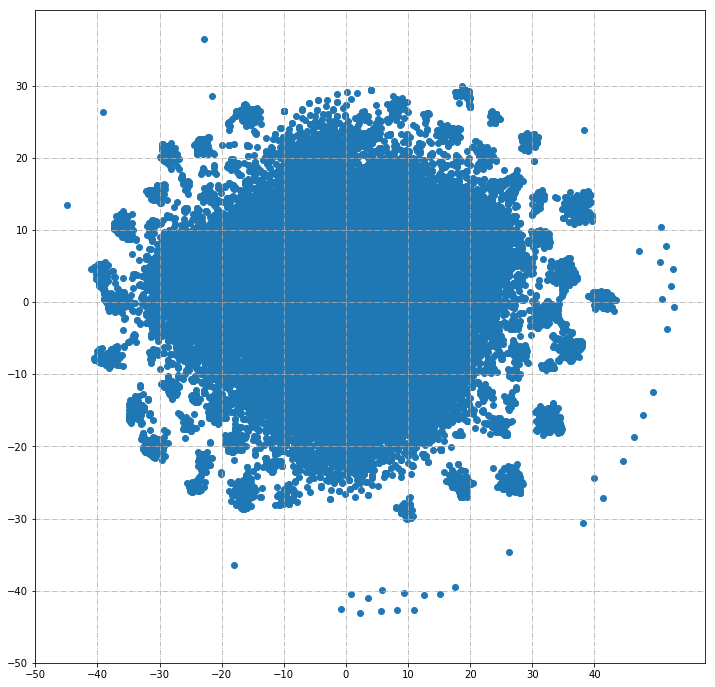

In [111]:
plot_vectors(low_dim_embs)

In [164]:
low_dim_embs[w2i_dict["waste"]]

array([38.046997, -6.103097], dtype=float32)

In [153]:
# find grid cluster
cond = [-32, -30, -21, -19]
loc = np.where(
    (low_dim_embs[:, 0] > cond[0]).astype(np.int32) * (low_dim_embs[:, 0] < cond[1]).astype(np.int32)
    * (low_dim_embs[:, 1]> cond[2]).astype(np.int32) * (low_dim_embs[:, 1] < cond[3]).astype(np.int32)) [0]

In [154]:
# min, max, avg
print(np.min(low_dim_embs[loc], axis=0), np.max(low_dim_embs[loc], axis=0), np.average(low_dim_embs[loc], axis=0))

[-31.98224  -20.990255] [-30.018105 -19.056053] [-31.120588 -20.25569 ]


In [155]:
# cluster words
for l in loc: print(l, i2w_dict[l])

148 life
324 job
410 wonderful
624 end.
891 ways
1456 pieces
1518 fresh
1902 pleasure
2287 walks
2328 learns
2344 contemporary
2533 ain
2873 seasons
3354 society.
3538 forever.
3588 title.
3896 cool.
3936 consequences
4153 liking
4222 anyways
4449 intrigue
4659 forbidden
4726 nervous
4785 punishment
5015 purchase
5119 bernard
5350 repeating
5671 bay
5881 deserted
6005 awe
6278 hayes
7024 lang
7405 reserved
7912 interrupted
8147 1000
8302 spinal
8845 officials
8891 commanding
9003 coma
9331 swanson
9511 manipulated
9773 forties
10103 tempest
10810 barnes
10900 kenny
11299 big-budget
11335 heal
11583 agreement
11645 duff
11896 dom
11926 rarity
12030 chiller
12066 viewings.
12483 cafe
12603 scaring
13141 atkinson
13377 splitting
13630 shia
13885 individuals.
13927 eyeball
14051 announce
14360 picky
14680 2007.
15272 schlesinger
15538 coroner
15707 wyatt
15727 schlocky
16013 attain
16131 alternating
16403 madge
16406 stirred
16556 yuen
16833 doppelganger
17152 vulcan
17350 donnell
17476 li

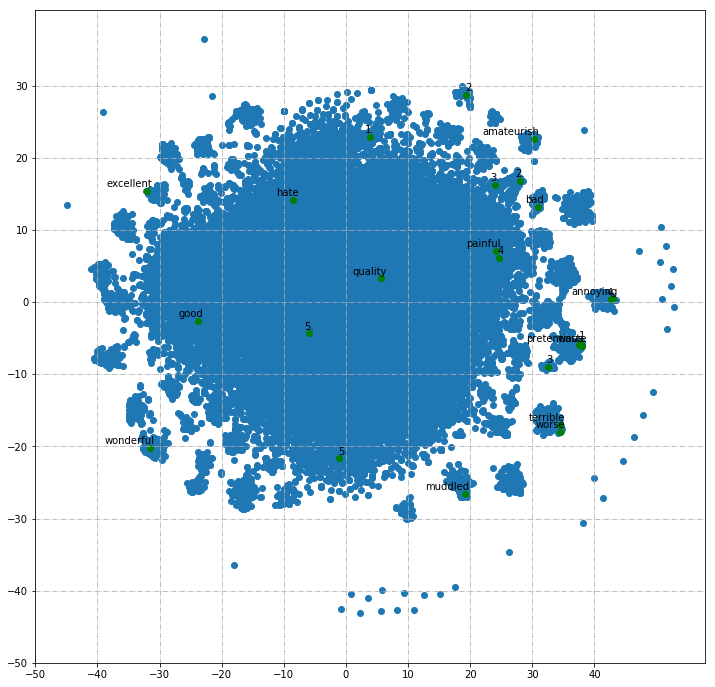

In [179]:
# compare
compare_words = ["terrible", "bad", "good", "excellent", "hate", "painful", "worse", "wonderful", "amateurish", "pretentious",
                "annoying", "quality", "waste", "muddled", "1", "2", "3", "4", "5", "1.", "2.", "3.", "4.", "5."]
plot_vectors_comp(low_dim_embs, compare_words)

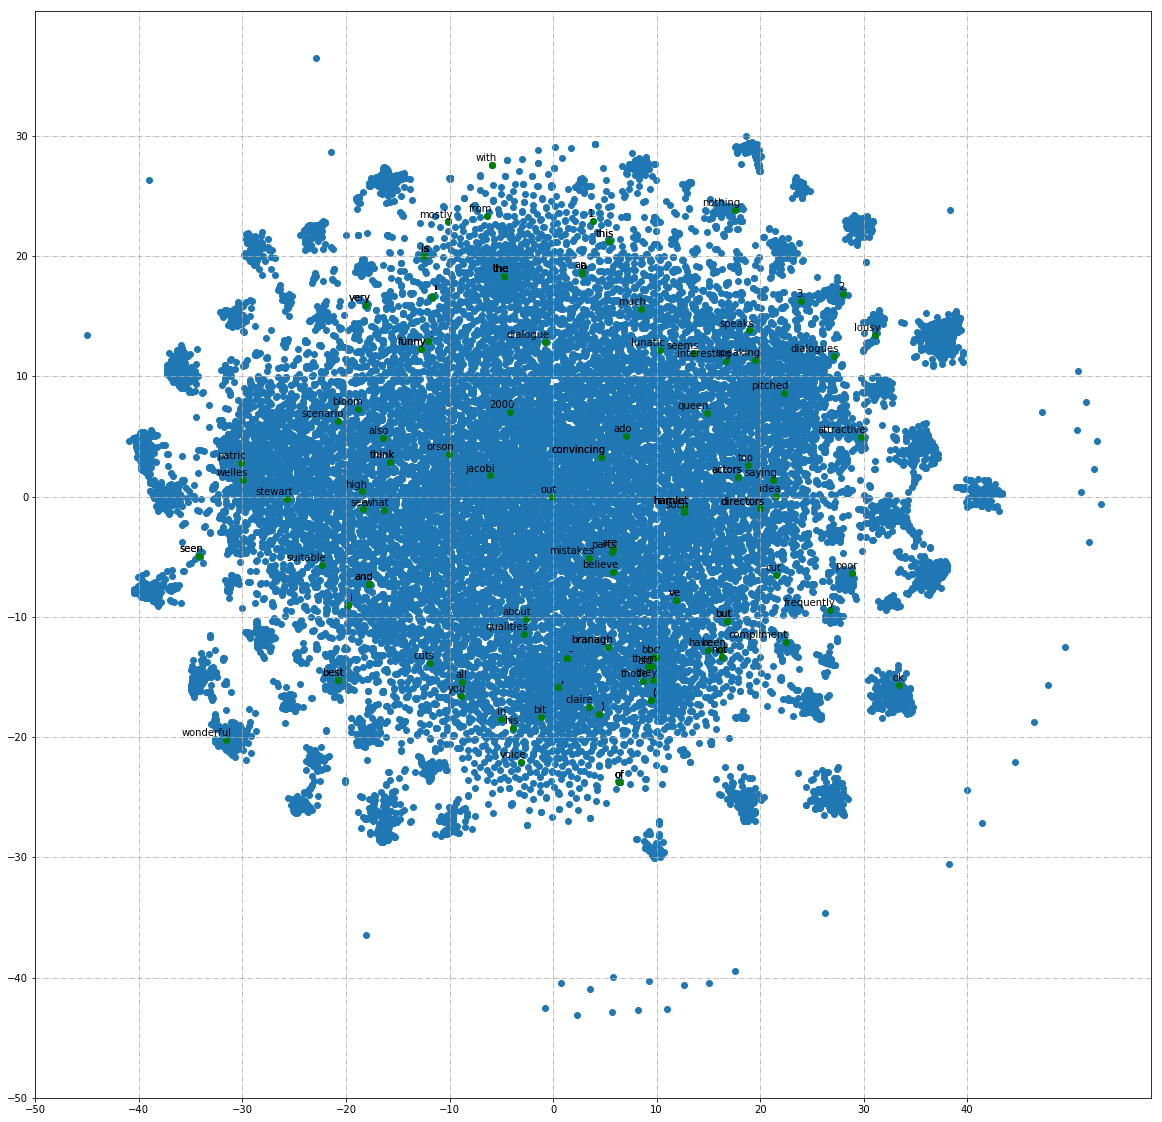

In [176]:
plot_vectors_comp_doc(low_dim_embs, [w for w in X_test[32] if w != 0], size=(20, 20))